# TensorFlow MNIST

In [695]:
import numpy as np
import tensorflow as tf
import idx2numpy
import time
import sys

from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from matplotlib import cm
figsize(4, 4)

## Read In Data

In [318]:
prefix = "/Users/jeffreyschecter/Desktop/mnist/"
train_im = idx2numpy.convert_from_file(prefix + "train-images-idx3-ubyte")
test_im = idx2numpy.convert_from_file(prefix + "t10k-images-idx3-ubyte")

In [319]:
train_labels = idx2numpy.convert_from_file(prefix + "train-labels-idx1-ubyte")
test_labels = idx2numpy.convert_from_file(prefix + "t10k-labels-idx1-ubyte")

## Throw a random forest at it

In [320]:
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    n_jobs=-1)
clf.fit(train_im.reshape(60000, 28 * 28), train_labels)
model_labels = clf.predict(test_im.reshape(10000, 28 * 28))
(model_labels == test_labels).mean()

0.96940000000000004

In [321]:
misses = test_im[(model_labels != test_labels)]
miss_test_labels = test_labels[(model_labels != test_labels)]
miss_guess_labels = model_labels[(model_labels != test_labels)]

In [322]:
confusion = np.zeros((10, 10), dtype=np.int)
for guess, target in zip(miss_guess_labels, miss_test_labels):
    confusion[guess, target] += 1

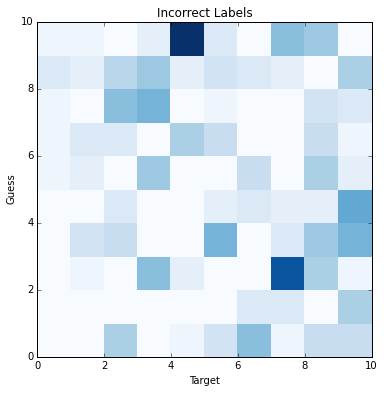

In [323]:
figsize(6, 6)
plt.pcolor(confusion, cmap=cm.Blues)
plt.xlabel("Target")
plt.ylabel("Guess")
plt.title("Incorrect Labels")
plt.show()

## Simple softmax regression w/ TensorFlow
Based on the TensorFlow tutorial at http://tensorflow.org/tutorials/mnist/pros/index.md

In [324]:
try:
    del(sess)
    print "deleted session"
except Exception as e:
    print "no existing session to delete"
sess = tf.InteractiveSession()

deleted session


In [325]:
x = tf.placeholder(tf.float32, shape=[None, 28 * 28])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
W = tf.Variable(tf.zeros([28 * 28, 10]))
b = tf.Variable(tf.zeros([10]))

sess.run(tf.initialize_all_variables())

In [326]:
y = tf.nn.softmax(tf.matmul(x, W) + b)
xent = -tf.reduce_mean(y_ * tf.log(y))
train_step = tf.train.GradientDescentOptimizer(0.0001).minimize(xent)

In [327]:
train_labels_one_hot = np.zeros((60000, 10))
train_labels_one_hot[np.arange(60000), train_labels] = 1
test_labels_one_hot = np.zeros((10000, 10))
test_labels_one_hot[np.arange(10000), test_labels] = 1

In [328]:
batch_size = 1000
epochs = 10
for ep in xrange(epochs):
    print "Starting training epoch {ep}".format(ep=ep)
    for i in xrange(train_im.shape[0] / batch_size):
        start_offset = i * batch_size
        stop_offset = start_offset + batch_size
        train_step.run(feed_dict={
            x: train_im[start_offset:stop_offset].reshape(batch_size, 28 * 28),
            y_: train_labels_one_hot[start_offset:stop_offset]
        })
    accuracy_expr = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1)), tf.float32))
    accuracy = accuracy_expr.eval(feed_dict={
        x: test_im.reshape(10000, 28 * 28),
        y_: test_labels_one_hot})
    print accuracy
    

Starting training epoch 0
0.893
Starting training epoch 1
0.9041
Starting training epoch 2
0.9092
Starting training epoch 3
0.9115
Starting training epoch 4
0.9139
Starting training epoch 5
0.9156
Starting training epoch 6
0.9165
Starting training epoch 7
0.9177
Starting training epoch 8
0.9186
Starting training epoch 9
0.9195


## Simple ConvNet w/ TensorFlow
Still based off of the TensorFlow tutorial.

In [571]:
try:
    del(sess)
    print "deleted session"
except Exception as e:
    print "no existing session to delete"
sess = tf.InteractiveSession()

deleted session


In [572]:
def weight_variable(shape, init=0.01):
    initial = tf.random_uniform(shape, minval=-init, maxval=init)
    return tf.Variable(initial, name="weights")

def bias_variable(shape, init=0.01):
    initial = tf.constant(init, shape=shape)
    return tf.Variable(initial, name="bias")

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name="conv")

def max_pool_2x2(x):
    return tf.nn.max_pool(
        x, ksize=[1, 2, 2, 1],
        strides=[1, 2, 2, 1], padding='SAME', name="max_pool")

def elu(x):
    pos = tf.cast(tf.greater_equal(x, 0), tf.float32)
    return (pos * x) + ((1 - pos) * (tf.exp(x) - 1))

#### Inputs

In [573]:
x = tf.placeholder(tf.float32, [None, 28, 28])
y_ = tf.placeholder(tf.float32, [None, 10])

#### Internal Structure and Outputs

In [574]:
# Compare elu vs. tf.nnet.relu
nonlin = elu

with tf.name_scope("conv1") as scope:
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = nonlin(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

with tf.name_scope("conv2") as scope:
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = nonlin(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

with tf.name_scope("dense") as scope:
    W_dense = weight_variable([7 * 7 * 64, 1024])
    b_dense = bias_variable([1024])
    h_dense = nonlin(tf.matmul(tf.reshape(h_pool2, [-1, 7 * 7 * 64]), W_dense) + b_dense)

with tf.name_scope("dropout") as scope:
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    h_dropout = tf.nn.dropout(h_dense, keep_prob)

with tf.name_scope("softmax_output") as scope:
    W_out = weight_variable([1024, 10])
    b_out = bias_variable([10])
    y = tf.nn.softmax(tf.matmul(h_dropout, W_out) + b_out)

#### Training, Evaluation, and Initilization

In [575]:
xent = -tf.reduce_mean(y_ * tf.log(y))
train_step = tf.train.AdamOptimizer(0.0001).minimize(xent)
correct = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

sess.run(tf.initialize_all_variables())

#### Main Loop

In [576]:
num_epochs = 10
batch_size = 200
dropout_keep_rate = 0.5
test_every_n_batches = 50
decay_factor = 5

batches_per_epoch = train_im.shape[0] / batch_size
mark = time.time()
for ep in xrange(num_epochs):
    for i in xrange(batches_per_epoch):
        sys.stdout.write(".")
        sys.stdout.flush()
        start_offset = i * batch_size
        stop_offset = start_offset + batch_size
        train_step.run(feed_dict={
            x: train_im[start_offset:stop_offset],
            y_: train_labels_one_hot[start_offset:stop_offset],
            keep_prob: dropout_keep_rate})
        if i % test_every_n_batches == 0:
            ac = accuracy.eval(feed_dict={
                x: test_im[:1000],
                y_: test_labels_one_hot[:1000],
                keep_prob: 1.0})
            print "\nFinished epoch {ep}, batch {ba} after {t:.2f} seconds: accuracy = {ac:.3f}".format(
                ep=ep, ba=i, t=time.time() - mark, ac=ac)
    ac = accuracy.eval(feed_dict={
        x: test_im,
        y_: test_labels_one_hot,
        keep_prob: 1.0})
    print "\nEND OF EPOCH {ep}: accuracy = {ac:.4f}".format(ep=ep, ac=ac)

.
Finished epoch 0, batch 0 after 3.69 seconds: accuracy = 0.476
..................................................
Finished epoch 0, batch 50 after 53.95 seconds: accuracy = 0.891
..................................................
Finished epoch 0, batch 100 after 103.71 seconds: accuracy = 0.939
..................................................
Finished epoch 0, batch 150 after 152.90 seconds: accuracy = 0.957
..................................................
Finished epoch 0, batch 200 after 201.73 seconds: accuracy = 0.967
..................................................
Finished epoch 0, batch 250 after 251.84 seconds: accuracy = 0.977
.................................................
END OF EPOCH 0: accuracy = 0.9729
.
Finished epoch 1, batch 0 after 316.40 seconds: accuracy = 0.975
..................................................
Finished epoch 1, batch 50 after 368.32 seconds: accuracy = 0.976
..................................................
Finished epoch 1, batch 100 

### Build a random forest based on hidden layer activations

In [577]:
hidden_list = []
for i in xrange(60):
    mark = time.time()
    hidden_list.append(
        h_dropout.eval(feed_dict={
            keep_prob: 1.0,
            x: train_im[i * 1000:(i + 1) * 1000]}))
    print "Batch {b} in {t:.2f} seconds".format(b=i, t=time.time() - mark)

Batch 0 in 2.17 seconds
Batch 1 in 1.88 seconds
Batch 2 in 1.97 seconds
Batch 3 in 2.11 seconds
Batch 4 in 2.23 seconds
Batch 5 in 1.88 seconds
Batch 6 in 1.85 seconds
Batch 7 in 1.89 seconds
Batch 8 in 1.95 seconds
Batch 9 in 1.99 seconds
Batch 10 in 1.91 seconds
Batch 11 in 1.81 seconds
Batch 12 in 1.77 seconds
Batch 13 in 1.81 seconds
Batch 14 in 1.79 seconds
Batch 15 in 2.09 seconds
Batch 16 in 2.09 seconds
Batch 17 in 1.94 seconds
Batch 18 in 2.05 seconds
Batch 19 in 1.85 seconds
Batch 20 in 1.83 seconds
Batch 21 in 1.83 seconds
Batch 22 in 1.77 seconds
Batch 23 in 1.91 seconds
Batch 24 in 1.81 seconds
Batch 25 in 1.81 seconds
Batch 26 in 1.86 seconds
Batch 27 in 2.00 seconds
Batch 28 in 1.93 seconds
Batch 29 in 1.90 seconds
Batch 30 in 1.89 seconds
Batch 31 in 1.87 seconds
Batch 32 in 1.83 seconds
Batch 33 in 1.90 seconds
Batch 34 in 1.92 seconds
Batch 35 in 1.88 seconds
Batch 36 in 1.87 seconds
Batch 37 in 1.89 seconds
Batch 38 in 1.91 seconds
Batch 39 in 1.93 seconds
Batch 40 i

In [578]:
hidden_train = np.array(hidden_list).reshape(60000, 1024)

In [579]:
hidden_list = []
for i in xrange(10):
    mark = time.time()
    hidden_list.append(
        h_dropout.eval(feed_dict={
            keep_prob: 1.0,
            x: test_im[i * 1000:(i + 1) * 1000]}))
    print "Batch {b} in {t:.2f} seconds".format(b=i, t=time.time() - mark)

Batch 0 in 2.33 seconds
Batch 1 in 2.30 seconds
Batch 2 in 2.11 seconds
Batch 3 in 1.97 seconds
Batch 4 in 1.88 seconds
Batch 5 in 1.82 seconds
Batch 6 in 2.18 seconds
Batch 7 in 2.00 seconds
Batch 8 in 1.86 seconds
Batch 9 in 1.80 seconds


In [580]:
hidden_test = np.array(hidden_list).reshape(10000, 1024)

In [581]:
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    n_jobs=-1)
clf.fit(hidden_train, train_labels)
model_labels = clf.predict(hidden_test)
(model_labels == test_labels).mean()

0.99229999999999996

In [582]:
misses = test_im[(model_labels != test_labels)]
miss_test_labels = test_labels[(model_labels != test_labels)]
miss_guess_labels = model_labels[(model_labels != test_labels)]

#### Example Mis-Classified Digits

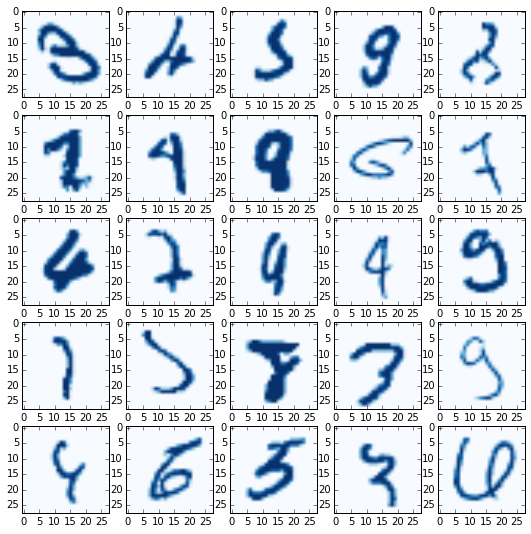

In [583]:
figsize(9, 9)
_, axes = plt.subplots(5, 5)
axes = axes.reshape(25)

for x in xrange(25):
    im = misses[x]
    test_label = miss_test_labels[x]
    guess_label = miss_guess_labels[x]
    ax = axes[x]
    ax.imshow(im, cmap=cm.Blues)
plt.show()

In [584]:
confusion = np.zeros((10, 10), dtype=np.int)
for guess, target in zip(miss_guess_labels, miss_test_labels):
    confusion[guess, target] += 1

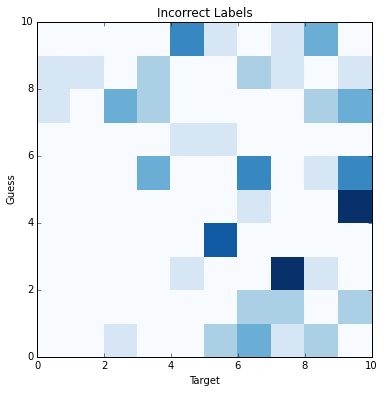

In [585]:
figsize(6, 6)
plt.pcolor(confusion, cmap=cm.Blues)
plt.xlabel("Target")
plt.ylabel("Guess")
plt.title("Incorrect Labels")
plt.show()

## Deep Autoencoder
Going a bit further afield. There are two strategies to building autoencoders: either train all the layers at the same time, or train each layer in isolation, and freeze it before moving on to the next. The second approach isn't needed for something as simple as the MNIST dataset.

In [757]:
try:
    del(sess)
    print "deleted session"
except Exception as e:
    print "no existing session to delete"
sess = tf.InteractiveSession()

deleted session


#### Inputs

In [758]:
x = tf.placeholder(tf.float32, shape=[None, 28, 28])

#### Internal Structure and Outputs

In [759]:
def HiddenLayer(inp, shape, nonlin=elu, init=0.001, scope="RBM"):
    with tf.name_scope(scope) as ns:
        W = weight_variable(shape, init=init)
        b = bias_variable([shape[1]], init=init)
        h = nonlin(tf.matmul(inp, W) + b)
        return W, b, h

# Munge input
with tf.name_scope("enc_input") as scope:
    x_scaled = x / 255.0
    x_flat = tf.reshape(x_scaled, [-1, 28 * 28])

# Encoder
W_enc1, b_enc1, h_enc1 = HiddenLayer(
    x_flat, [28 * 28, 256], scope="enc1")
W_enc2, b_enc2, h_enc2 = HiddenLayer(
    h_enc1, [256, 128], scope="enc2")
W_enc3, b_enc3, h_enc3 = HiddenLayer(
    h_enc2, [128, 64], scope="enc3")
W_enc4, b_enc4, h_enc4 = HiddenLayer(
    h_enc3, [64, 32], scope="enc4")

# Decoder
W_dec4, b_dec4, h_dec4 = HiddenLayer(
    h_enc4, [32, 64], scope="dec5")
W_dec3, b_dec3, h_dec3 = HiddenLayer(
    h_dec4, [64, 128], scope="dec4")
W_dec2, b_dec2, h_dec2 = HiddenLayer(
    h_dec3, [128, 256], scope="dec2")
W_dec1, b_dec1, h_dec1 = HiddenLayer(
    h_dec2, [256, 28 * 28], nonlin=tf.nn.sigmoid, scope="dec1")

# Munge output
with tf.name_scope("dec_output") as scope:
    y = tf.reshape(h_dec1, [-1, 28, 28])
    y_image = 255 * y

#### Training, Evaluation, and Initialization

In [683]:
mse = tf.reduce_mean(tf.pow(y - x_scaled, 2))
train_step = tf.train.AdamOptimizer(0.001).minimize(mse)

sess.run(tf.initialize_all_variables())

#### Main loop


START OF EPOCH 0: MSE=2.317e-01


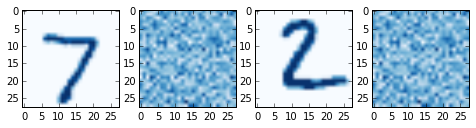

Finished epoch 0, batch 249 after 9.36 sec: MSE=6.209e-02, max activation=5.209e+00
Finished epoch 0, batch 499 after 15.77 sec: MSE=6.077e-02, max activation=7.381e+00

START OF EPOCH 1: MSE=6.907e-02


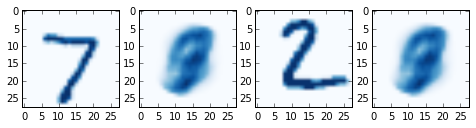

Finished epoch 1, batch 249 after 26.29 sec: MSE=6.019e-02, max activation=1.397e+01
Finished epoch 1, batch 499 after 32.67 sec: MSE=5.938e-02, max activation=1.585e+01

START OF EPOCH 2: MSE=6.241e-02


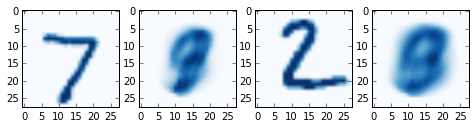

Finished epoch 2, batch 249 after 42.60 sec: MSE=5.919e-02, max activation=1.605e+01
Finished epoch 2, batch 499 after 48.84 sec: MSE=5.773e-02, max activation=1.921e+01

START OF EPOCH 3: MSE=6.067e-02


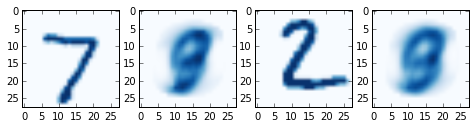

Finished epoch 3, batch 249 after 58.34 sec: MSE=5.654e-02, max activation=2.231e+01
Finished epoch 3, batch 499 after 64.66 sec: MSE=5.537e-02, max activation=2.685e+01

START OF EPOCH 4: MSE=5.805e-02


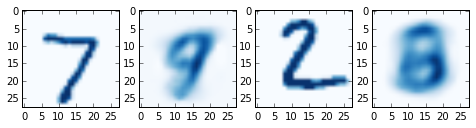

Finished epoch 4, batch 249 after 74.38 sec: MSE=5.530e-02, max activation=3.167e+01
Finished epoch 4, batch 499 after 80.56 sec: MSE=5.392e-02, max activation=3.302e+01

START OF EPOCH 5: MSE=5.702e-02


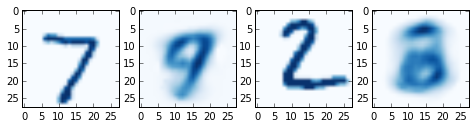

Finished epoch 5, batch 249 after 90.52 sec: MSE=5.207e-02, max activation=4.140e+01
Finished epoch 5, batch 499 after 96.77 sec: MSE=4.832e-02, max activation=4.518e+01

START OF EPOCH 6: MSE=5.015e-02


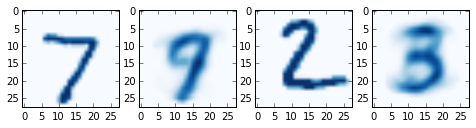

Finished epoch 6, batch 249 after 107.63 sec: MSE=4.649e-02, max activation=4.711e+01
Finished epoch 6, batch 499 after 114.47 sec: MSE=4.438e-02, max activation=4.114e+01

START OF EPOCH 7: MSE=4.971e-02


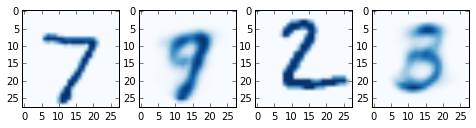

Finished epoch 7, batch 249 after 125.01 sec: MSE=4.239e-02, max activation=3.867e+01
Finished epoch 7, batch 499 after 132.47 sec: MSE=4.102e-02, max activation=3.407e+01

START OF EPOCH 8: MSE=4.333e-02


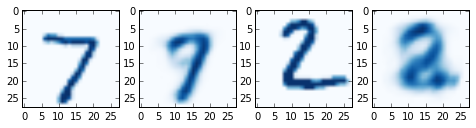

Finished epoch 8, batch 249 after 144.26 sec: MSE=3.975e-02, max activation=3.508e+01
Finished epoch 8, batch 499 after 151.16 sec: MSE=3.734e-02, max activation=3.647e+01

START OF EPOCH 9: MSE=3.969e-02


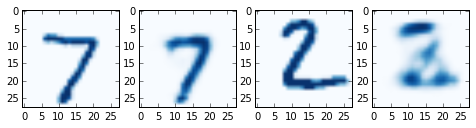

Finished epoch 9, batch 249 after 163.85 sec: MSE=3.487e-02, max activation=3.363e+01
Finished epoch 9, batch 499 after 171.40 sec: MSE=3.439e-02, max activation=3.050e+01

START OF EPOCH 10: MSE=3.595e-02


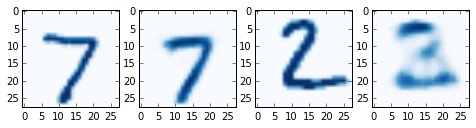

Finished epoch 10, batch 249 after 182.69 sec: MSE=3.278e-02, max activation=2.805e+01
Finished epoch 10, batch 499 after 189.94 sec: MSE=3.174e-02, max activation=2.621e+01

START OF EPOCH 11: MSE=3.383e-02


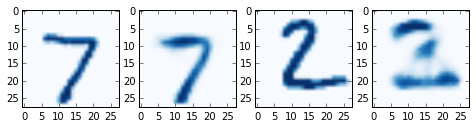

Finished epoch 11, batch 249 after 200.90 sec: MSE=3.048e-02, max activation=2.793e+01
Finished epoch 11, batch 499 after 207.95 sec: MSE=2.970e-02, max activation=2.754e+01

START OF EPOCH 12: MSE=3.112e-02


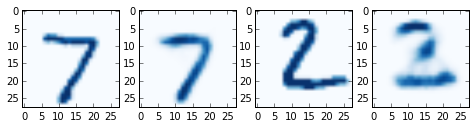

Finished epoch 12, batch 249 after 220.27 sec: MSE=2.765e-02, max activation=3.135e+01
Finished epoch 12, batch 499 after 227.07 sec: MSE=2.645e-02, max activation=2.641e+01

START OF EPOCH 13: MSE=2.932e-02


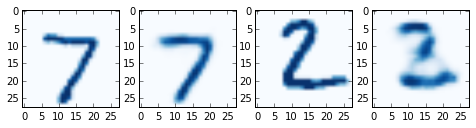

Finished epoch 13, batch 249 after 238.65 sec: MSE=2.605e-02, max activation=2.752e+01
Finished epoch 13, batch 499 after 245.73 sec: MSE=2.526e-02, max activation=2.401e+01

START OF EPOCH 14: MSE=2.744e-02


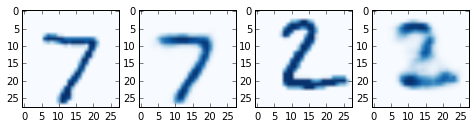

Finished epoch 14, batch 249 after 256.74 sec: MSE=2.505e-02, max activation=2.546e+01
Finished epoch 14, batch 499 after 264.31 sec: MSE=2.367e-02, max activation=2.518e+01

START OF EPOCH 15: MSE=2.633e-02


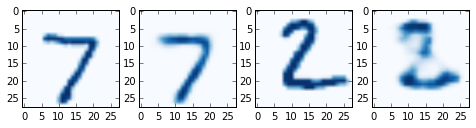

Finished epoch 15, batch 249 after 275.17 sec: MSE=2.312e-02, max activation=2.610e+01
Finished epoch 15, batch 499 after 281.74 sec: MSE=2.233e-02, max activation=2.617e+01

START OF EPOCH 16: MSE=2.495e-02


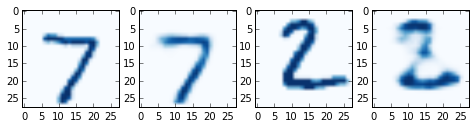

Finished epoch 16, batch 249 after 292.35 sec: MSE=2.197e-02, max activation=2.611e+01
Finished epoch 16, batch 499 after 298.88 sec: MSE=2.142e-02, max activation=2.480e+01

START OF EPOCH 17: MSE=2.338e-02


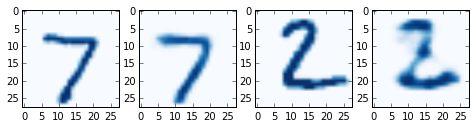

Finished epoch 17, batch 249 after 309.24 sec: MSE=2.095e-02, max activation=2.628e+01
Finished epoch 17, batch 499 after 316.04 sec: MSE=2.075e-02, max activation=2.480e+01

START OF EPOCH 18: MSE=2.236e-02


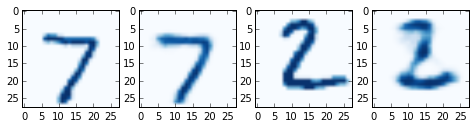

Finished epoch 18, batch 249 after 326.05 sec: MSE=2.003e-02, max activation=2.640e+01
Finished epoch 18, batch 499 after 332.93 sec: MSE=2.001e-02, max activation=2.466e+01

START OF EPOCH 19: MSE=2.131e-02


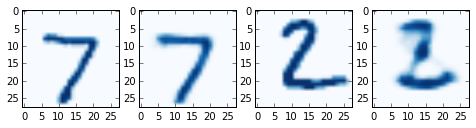

Finished epoch 19, batch 249 after 343.23 sec: MSE=1.933e-02, max activation=2.509e+01
Finished epoch 19, batch 499 after 349.68 sec: MSE=1.931e-02, max activation=2.379e+01

START OF EPOCH 20: MSE=2.060e-02


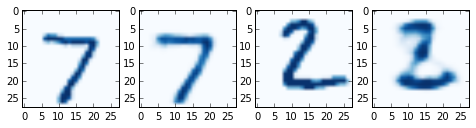

Finished epoch 20, batch 249 after 359.73 sec: MSE=1.874e-02, max activation=2.466e+01
Finished epoch 20, batch 499 after 366.06 sec: MSE=1.851e-02, max activation=2.268e+01

START OF EPOCH 21: MSE=1.996e-02


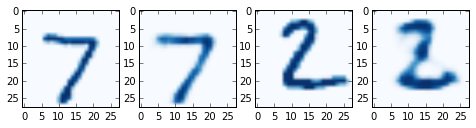

Finished epoch 21, batch 249 after 375.39 sec: MSE=1.800e-02, max activation=2.341e+01
Finished epoch 21, batch 499 after 382.01 sec: MSE=1.778e-02, max activation=2.168e+01

START OF EPOCH 22: MSE=1.931e-02


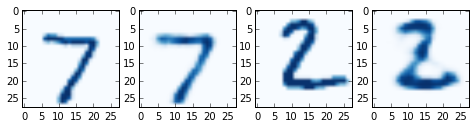

Finished epoch 22, batch 249 after 391.85 sec: MSE=1.729e-02, max activation=2.216e+01
Finished epoch 22, batch 499 after 397.96 sec: MSE=1.714e-02, max activation=2.100e+01

START OF EPOCH 23: MSE=1.890e-02


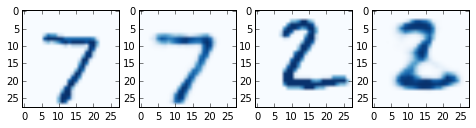

Finished epoch 23, batch 249 after 407.52 sec: MSE=1.678e-02, max activation=2.107e+01
Finished epoch 23, batch 499 after 413.99 sec: MSE=1.667e-02, max activation=2.018e+01

START OF EPOCH 24: MSE=1.841e-02


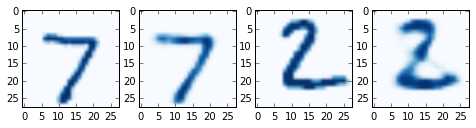

Finished epoch 24, batch 249 after 424.14 sec: MSE=1.640e-02, max activation=1.994e+01
Finished epoch 24, batch 499 after 430.65 sec: MSE=1.624e-02, max activation=1.934e+01

START OF EPOCH 25: MSE=1.805e-02


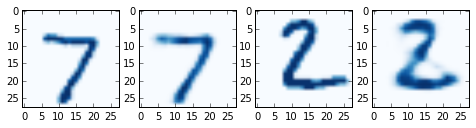

Finished epoch 25, batch 249 after 440.58 sec: MSE=1.586e-02, max activation=1.906e+01
Finished epoch 25, batch 499 after 447.52 sec: MSE=1.564e-02, max activation=1.914e+01

START OF EPOCH 26: MSE=1.744e-02


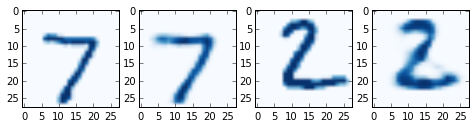

Finished epoch 26, batch 249 after 458.15 sec: MSE=1.523e-02, max activation=1.862e+01
Finished epoch 26, batch 499 after 464.37 sec: MSE=1.488e-02, max activation=1.895e+01

START OF EPOCH 27: MSE=1.656e-02


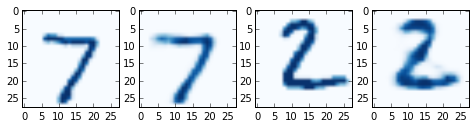

Finished epoch 27, batch 249 after 474.29 sec: MSE=1.472e-02, max activation=1.821e+01
Finished epoch 27, batch 499 after 480.61 sec: MSE=1.446e-02, max activation=1.875e+01

START OF EPOCH 28: MSE=1.570e-02


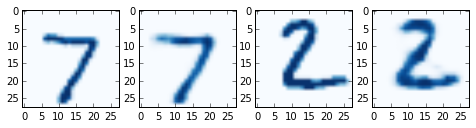

Finished epoch 28, batch 249 after 490.87 sec: MSE=1.432e-02, max activation=1.821e+01
Finished epoch 28, batch 499 after 497.90 sec: MSE=1.414e-02, max activation=1.853e+01

START OF EPOCH 29: MSE=1.503e-02


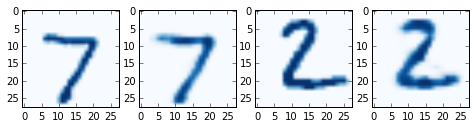

Finished epoch 29, batch 249 after 507.20 sec: MSE=1.392e-02, max activation=1.831e+01
Finished epoch 29, batch 499 after 513.35 sec: MSE=1.364e-02, max activation=1.821e+01


In [684]:
num_epochs = 30
batch_size = 100
test_every_n_batches = 250

figsize(8, 2)

batches_per_epoch = train_im.shape[0] / batch_size
mark = time.time()
for ep in xrange(num_epochs):
    er = mse.eval(feed_dict={x: test_im})
    print "\nSTART OF EPOCH {ep}: MSE={er:.3e}".format(ep=ep, er=er)
    _, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    ax1.imshow(test_im[0], cmap=cm.Blues)
    ax2.imshow(y_image.eval(feed_dict={x: test_im[0:1]}).reshape(28, 28), cmap=cm.Blues)
    ax3.imshow(test_im[1], cmap=cm.Blues)
    ax4.imshow(y_image.eval(feed_dict={x: test_im[1:2]}).reshape(28, 28), cmap=cm.Blues)
    plt.show()
    for i in xrange(batches_per_epoch):
        start_offset = i * batch_size
        stop_offset = start_offset + batch_size
        train_step.run(feed_dict={x: train_im[start_offset:stop_offset]})
        if (i + 1) % test_every_n_batches == 0:
            er, he1, he2, hd1, hd2 = sess.run(
                [mse, h_enc1, h_enc2, h_dec1, h_dec2],
                feed_dict={x: test_im[:100]})
            mv = max(he1.max(), he2.max(), hd1.max(), hd2.max())
            print ("Finished epoch {ep}, batch {ba} after {t:.2f} sec: "
                   "MSE={er:.3e}, max activation={mv:.3e}").format(
                ep=ep, ba=i, t=time.time() - mark, er=er, mv=mv)
            sys.stdout.flush()
    

### Random Forest based on Autoencoder Compressed Representation

In [685]:
compressed_train = h_enc4.eval({x: train_im})
compressed_test = h_enc4.eval({x: test_im})

In [686]:
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    n_jobs=-1)
clf.fit(compressed_train, train_labels)
model_labels = clf.predict(compressed_test)
(model_labels == test_labels).mean()

0.96079999999999999

### Visualize the Components of the Compressed Representation
Generate a visualization for each index in the most compressed representation by pegging the activation of the unit at that index to 1 and all other activations to 0, then propogating forward to the image output layer.

If our autoencoder is a success, these should be recognizeable as vaguely digit-esque pen strokes. If we botched it, we should see fuzzy blobs.

In [687]:
diag = np.zeros([32, 32])
np.fill_diagonal(diag, 1)
diag
components = y_image.eval(feed_dict={h_enc4: diag})

In [688]:
hidden_archetypes = [
    h_enc4.eval(feed_dict={x_scaled: test_im[test_labels == i] / 255.0}).mean(axis=0)
    for i in xrange(10)]

Average Activations of the Most Compressed Hidden Layer for Digit '5'


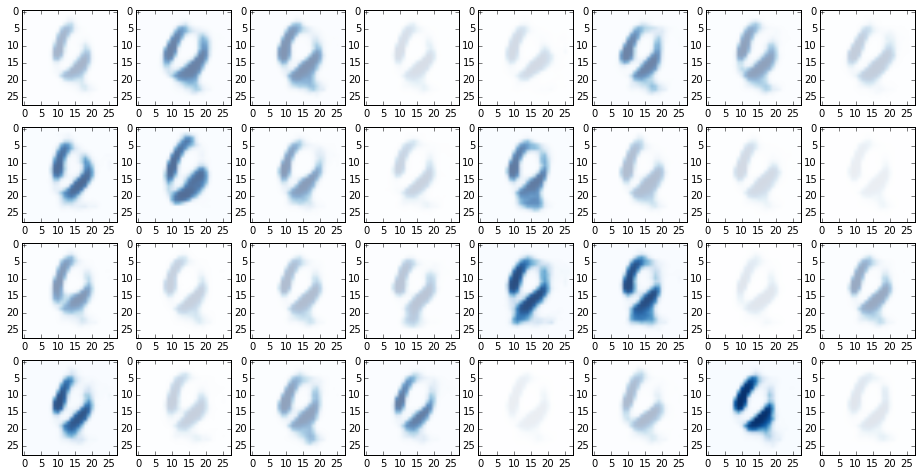

In [716]:
from ipywidgets import interact

figsize(16, 8)

def ShowComponentWeights(digit):
    print "Average Activations of the Most Compressed Hidden Layer for Digit '{i}'".format(i=digit)
    _, axes = plt.subplots(4, 8)
    axes = axes.reshape(32)
    max_weight = hidden_archetypes[digit].max() + 1
    for x, comp in enumerate(components):
        weight = (hidden_archetypes[digit][x] + 1) / max_weight
        axes[x].imshow(comp, alpha=weight, cmap=cm.Blues)

interact(ShowComponentWeights, digit=(0, 9))
None

### Visualizae "Archetypal" Images for Each Digit

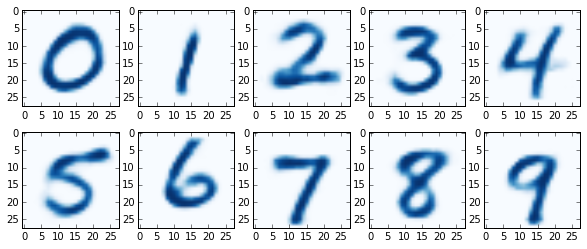

In [706]:
figsize(10, 4)
_, axes = plt.subplots(2, 5)
axes = axes.reshape(10)
for x, im in enumerate(y_image.eval(feed_dict={h_enc4: np.array(hidden_archetypes)})):
    axes[x].imshow(im, cmap=cm.Blues)

### Mixes between the compressed representations of different digits

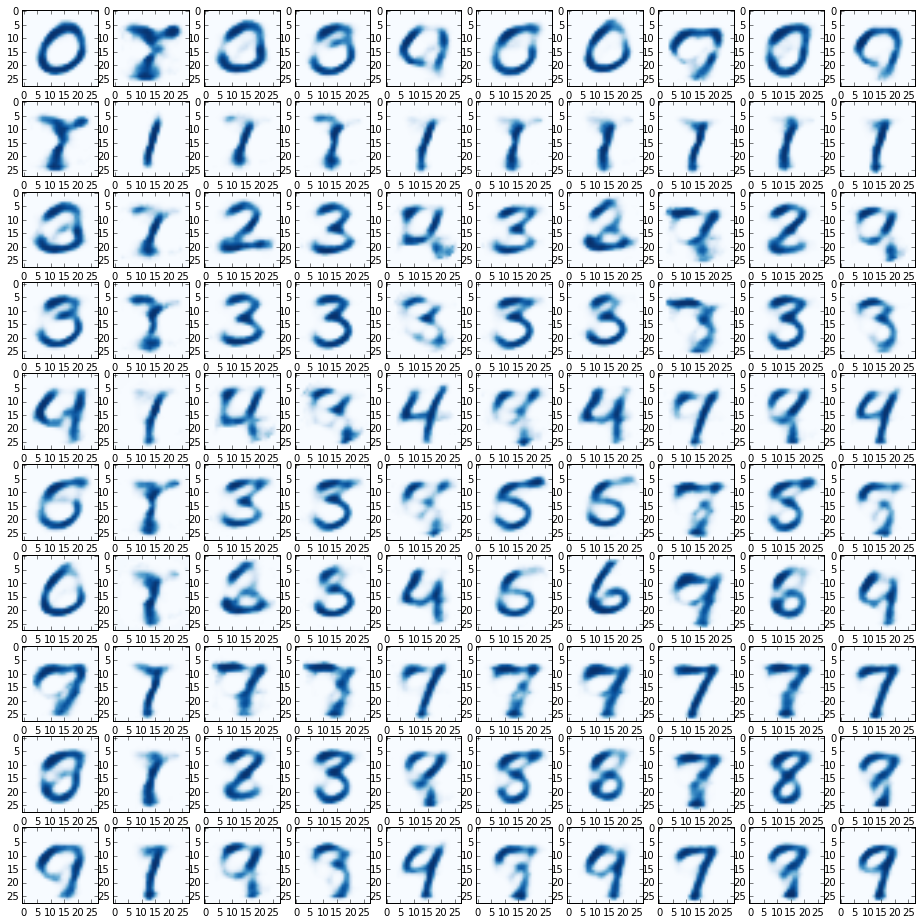

In [715]:
figsize(16, 16)
_, axes = plt.subplots(10, 10)
axes = axes.reshape(100)
for i in xrange(10):
    for j in xrange(10):
        mix = (0.55 * hidden_archetypes[i]) + (0.45 * hidden_archetypes[j])
        x = (10 * i) + j
        im = y_image.eval(feed_dict={h_enc4: np.array(mix).reshape(1, 32)}).reshape(28, 28)
        axes[x].imshow(im, cmap=cm.Blues)

### Illustration of Denoising
Random inputs on top row, resulting denoised reconstruction along the bottom.

#### Uniformly Distributed Noise

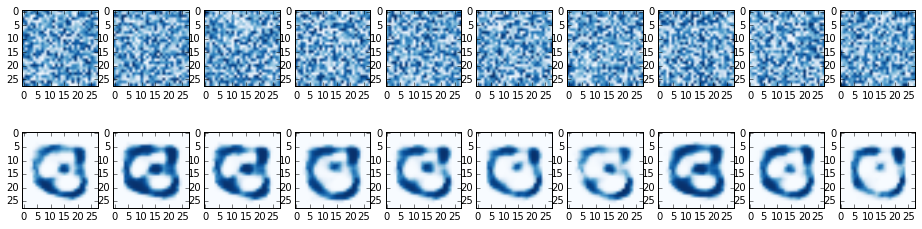

In [738]:
noise = np.random.random(size=(10, 28, 28))
denoised = y_image.eval(feed_dict={x_scaled: noise})
_, axes = plt.subplots(2, 10)
axes = axes.reshape(20)
for x in xrange(10):
    axes[x].imshow(noise[x], cmap=cm.Blues)
    axes[x + 10].imshow(denoised[x], cmap=cm.Blues)
plt.show()

## Generative Adversarial Networks
See http://arxiv.org/pdf/1406.2661v1.pdf

In [770]:
try:
    del(sess)
    print "deleted session"
except Exception as e:
    print "no existing session to delete"
sess = tf.InteractiveSession()

deleted session


#### Generative Network
The generative network maps a vector of uniform random noise inputs to a 28 x 28 1-channel image.

In [771]:
# Input a stack of 10-dimensional noise vectors.
# This spans the underlying object space of 10 digits.
G_x = tf.placeholder(tf.float32, [None, 10])

# Target vector is the probability of being real or a forger assigned by the discriminator.
G_y_ = tf.placeholder(tf.float32, [None, 1])

# Scale up input from 10 units to 28 * 28 = 784 units
G_W_s1, G_b_s1, G_h_s1 = HiddenLayer(G_x, [10, 32], scope="G_scaleup1")
G_W_s2, G_b_s2, G_h_s2 = HiddenLayer(G_h_s1, [32, 128], scope="G_scaleup2")
G_W_s3, G_b_s3, G_h_s3 = HiddenLayer(G_h_s2, [128, 512], scope="G_scaleup3")

# Apply dropout before last scaleup
with tf.name_scope("G_dropout") as scope:
    G_keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    G_h_dropout = tf.nn.dropout(G_h_s3, keep_prob)

# Scale up to final size, reshape to image dimensions
G_W_final, G_b_final, G_h_final = HiddenLayer(
    G_h_dropout, [512, 28 * 28], scope="G_scaleup_final")
G_out = tf.nn.sigmoid(tf.reshape(G_h_final, [-1, 28, 28]))
G_out_image = 255 * G_y

#### Discriminative Network

The discriminative network maps a 28 x 28 1-channel image to single float between 0 and 1, representing the probability that the image came from the training data distribution rather than the generative network.

In [772]:
# Input is a stack of 28 x 28 black and white images with activations from 0 to 255.
D_x = tf.placeholder(tf.float32, [None, 28, 28])

# Target vector is a 1 (real) or 0 (forgery) for each input.
D_y_ = tf.placeholder(tf.float32, [None, 1])

# Stack a couple of convolutional layers
nonlin = elu

with tf.name_scope("D_conv1") as scope:
    D_x_image = tf.reshape(x, [-1, 28, 28, 1])
    D_W_conv1 = weight_variable([5, 5, 1, 32])
    D_b_conv1 = bias_variable([32])
    D_h_conv1 = nonlin(conv2d(D_x_image, W_conv1) + D_b_conv1)
    D_h_pool1 = max_pool_2x2(D_h_conv1)

with tf.name_scope("D_conv2") as scope:
    D_W_conv2 = weight_variable([5, 5, 32, 64])
    D_b_conv2 = bias_variable([64])
    D_h_conv2 = nonlin(conv2d(D_h_pool1, D_W_conv2) + D_b_conv2)
    D_h_pool2 = max_pool_2x2(D_h_conv2)

# Hidden layer and dropout
with tf.name_scope("D_dense") as scope:
    D_W_dense = weight_variable([7 * 7 * 64, 256])
    D_b_dense = bias_variable([256])
    D_h_dense = nonlin(tf.matmul(tf.reshape(D_h_pool2, [-1, 7 * 7 * 64]), D_W_dense) + D_b_dense)

with tf.name_scope("D_dropout") as scope:
    D_keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    D_h_dropout = tf.nn.dropout(D_h_dense, D_keep_prob)

# Output a single float between 0 and 1
with tf.name_scope("D_output") as scope:
    D_W_out = weight_variable([256, 1])
    D_b_out = bias_variable([1])
    D_y = tf.nn.sigmoid(tf.matmul(D_h_dropout, D_W_out) + D_b_out)

#### Adversarial Training
0. Start with a batch of noise vectors.
1. Feed the noise vectors to the generator to create a batch of forgeries.
2. Mix in with a batch of real training images.
3. Train the discriminator on the mixed bag.
4. Train the generator on the noise vectors from step 0, using the output of the discriminator as the error signal.

In [ ]:
G_

D_mse = tf.reduce_mean(tf.pow(D_y_ - D_y, 2))
D_train_step = tf.train.AdamOptimizer(0.0001).minimize(D_mse)
D_accuracy = tf.reduce_mean(tf.equal(tf.cast(tf.greater_equal(D_y, 0.5), tf.float32), D_y_))


xent = -tf.reduce_mean(y_ * tf.log(y))
train_step = tf.train.AdamOptimizer(0.0001).minimize(xent)
correct = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

sess.run(tf.initialize_all_variables())
